In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# TensorFlow imports
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.utils import Sequence, to_categorical

from tensorflow.keras.callbacks import TensorBoard

from models.losses import Losses
from models.model import GMM_Survival
from utils.eval_utils import (accuracy_metric, calibration, cindex,
                              cindex_metric)
from utils.utils import ProgBar
tfd = tfp.distributions
tfkl = tf.keras.layers
tfpl = tfp.layers
tfk = tf.keras
# VaDeSC model

# Set Seaborn style for a cleaner look
sns.set(style="whitegrid")

print(os.getcwd())


# VaDeSC model


def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


def print_layer_details(layer, indent=0):
    indent_str = ' ' * indent
    print(f"{indent_str}Layer: {layer.name}")

    # Check if this layer contains sublayers
    if hasattr(layer, 'layers') and layer.layers:
        # If so, recursively print sublayer details
        for sublayer in layer.layers:
            print_layer_details(sublayer, indent + 2)
    else:
        # If not, it's a leaf node, print its variables
        if hasattr(layer, 'variables'):
            for var in layer.variables:
                print(f"{indent_str}  Variable: {var.name}, Shape: {var.shape}")
    # For layers without variables directly accessible, this part will be skipped

# Check for available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Using GPU:", gpus[0].name)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
else:
    print("No GPU found. Using CPU.")

2024-02-05 13:13:46.013549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 13:13:46.120233: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


/m/home/home9/97/nguyenq10/unix/HUS/cancer-clusters
Using GPU: /physical_device:GPU:0


2024-02-05 13:13:52.108412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-05 13:13:52.141609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-05 13:13:52.141706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Dataset

In [2]:
# from src.radcure import Radcure

def del_multicol(df):
    return df.drop(columns=df.filter(regex='^N Stage_N[1-9X]').columns).drop(columns=["T Stage_T3/4", "Stage_III/IV","ECOG_0"]) \
        .drop(columns=df.filter(regex='^Disease').columns).drop(columns="target_binary") \
        .drop(columns=["Sex_Female"])

# df_tr = Radcure.make_data("../data/radcure/clinical_train.csv")
# df_te = Radcure.make_data("/u/97/nguyenq10/unix/HUS/simpy-vadesc/data/radcure/clinical_test.csv")
df = pd.read_csv("./datasets/radcure/clinical_train.csv").drop(columns=["split","target_binary","Study ID"])
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df.columns = [col.lower().strip() for col in df.columns]
display(df.head())

cat_feats = ["sex", "disease site", "t stage", "n stage", "hpv combined", "chemo?", "ecog", "stage"]
num_feats = ["age"]
outcomes = df[["survival_time","death"]].rename(columns={"death":"event","survival_time":"time"})
features = df.drop(columns=["survival_time","death"])

from auton_survival.preprocessing import Preprocessor

preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat= 'mean') 
x = preprocessor.fit_transform(features, cat_feats=cat_feats, num_feats=num_feats,
                                one_hot=True, fill_value=-1)
y = outcomes


from sklearn.model_selection import train_test_split


x_tr, x_val, y_tr, y_val = train_test_split(x, y, test_size=0.3, random_state=1) 
dataset = "radcure"
# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()
print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
display(x.head())
display(y.head())

,age,sex,disease site,t stage,n stage,hpv combined,chemo?,ecog,stage,survival_time,death
0,66.7,male,larynx,t3,n0,NaN,0,0.0,iii,6.038356,0
1,68.4,female,hypopharynx,t2,n2b,NaN,0,1.0,iva,5.800000,0
2,49.7,female,nasopharynx,t1,n2,NaN,1,1.0,iii,7.556164,0
3,88.5,male,oropharynx,t2,n2a,NaN,0,2.0,iva,5.460274,0
4,69.8,male,oropharynx,t3,n2b,"yes, positive",0,0.0,iva,5.158904,0


Number of training data points: 1260
Number of validation data points: 540


,age,sex_male,disease site_hypopharynx,disease site_larynx,disease site_lip & oral cavity,disease site_nasal cavity,disease site_nasopharynx,disease site_oropharynx,disease site_paranasal sinus,disease site_salivary glands,...,ecog_4.0,stage_i,stage_ii,stage_iia,stage_iii,stage_iiia,stage_iiic,stage_iv,stage_iva,stage_ivb
0,0.397493,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.541164,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-1.039212,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2.239856,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.659480,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


,time,event
0,6.038356,0
1,5.800000,0
2,7.556164,0
3,5.460274,0
4,5.158904,0


## VaDeSC Model

In [45]:
class DataGen(Sequence):
    def __init__(self, X, y):
        self.X = X.values
        self.y = y.values

    def __getitem__(self, index):
        return (self.X, self.y), {"output_1": self.X, "output_5": self.y}

    def __len__(self):
        return 1
    
# Assuming x_tr is your numpy array of training data
gen_tr = DataGen(x_tr, y_tr)
gen_val = DataGen(x_val, y_val)

(next(iter(gen_tr))[0][0].shape,next(iter(gen_tr))[0][1].shape, )

((1260, 45), (1260, 2))

In [47]:
"Model"
from copy import deepcopy
from utils.utils import get_workdir

import torch
from auton_survival.metrics import phenotype_purity, survival_regression_metric
from lifelines.utils import concordance_index
from sklearn.model_selection import ParameterGrid
from torch.utils.tensorboard.writer import SummaryWriter

param_grid = {'num_clusters': [2],
              'learning_rate': [1e-3],
              "seed": [0],
              "layers": [[50,100]]
              }

params = ParameterGrid(param_grid)


# Define the times for tuning the model hyperparameters and for evaluating the model
# times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()
# Perform hyperparameter tuning
models = []
base_cfg = {"inp_shape": 45, "num_clusters": 2, "latent_dim": 8, 'monte_carlo': 1,
            'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False,
            "activation": None, "survival": True, "epochs":1000, "layers":[50,100]}
# Define reconstruction loss function
loss = Losses(base_cfg).loss_reconstruction_mse

cis = []


for param in params:
    cfg = deepcopy(base_cfg)
    for k, v in param.items():
        if k in cfg:
            cfg[k] = v
    print(cfg)
    # Construct the model & optimizer
    setup_seed(param["seed"])
    progress = ProgBar(epochs=cfg["epochs"],metrics=["loss","val_output_5_cindex_metric"])
    model = GMM_Survival(**cfg)
    tb_cb = tensorboard_callback = TensorBoard(log_dir=get_workdir(dataset), write_graph=True)
    tf.keras.backend.set_value(model.use_t, np.array([1.0]))
    optimizer = tf.keras.optimizers.legacy.Adam(
        learning_rate=param["learning_rate"], decay=0.00001)
    model.compile(optimizer, loss={"output_1": loss}, run_eagerly=False,
                  metrics={"output_5": cindex_metric})
    history = model.fit(gen_tr, validation_data=gen_val,
                        epochs=cfg["epochs"], verbose=0,
                        callbacks=[progress,tb_cb])
    print("loss", history.history['loss'][-1])
    rec, z_sample, p_z_c, p_c_z, risks, lambdas = model.predict((x_val.values, y_val.values))
    risks = np.squeeze(risks)
    phenotypes = np.argmax(p_c_z, -1)
    metric_val1 = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_val, 
                                    phenotypes_test=None, outcomes_test=None,
                                    strategy='integrated', horizons=[6], 
                                    bootstrap=None)
    # metric_val1 = survival_regression_metric(
    #     'ibs', y_val, predictions_val, times, y_tr)
    # metric_val2 = concordance_index(y_val.time, risk, y_val.event)

    models.append([metric_val1, model, param])
    ci = cindex(t=y_val.values[:, 0], e=y_val.values[:, 1], scores_pred=risks)
    print("ci", ci)
    cis.append(ci)


print(f"Concordance: {np.mean(cis)}(std. {np.std(cis)})")

# Select the best model based on the mean metric value computed for the validation set
models = sorted(models, key=lambda x: x[0], reverse=True)
best_model = models[0][1]
print(models)
print_layer_details(best_model)

{'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 8, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': None, 'survival': True, 'epochs': 1000, 'layers': [50, 100]}


Progress: 100%|██████████| 1000/1000 [01:29<00:00, 11.19it/s, loss=19.6899, val_output_5_cindex_metric=0.7380]


loss 19.689905166625977
17/17 [==============================] - 0s 2ms/step
ci 0.7379725852725534
Concordance: 0.7379725852725534(std. 0.0)
[[[0.13806853656366683], <models.model.GMM_Survival object at 0x7fd9545f3760>, {'layers': [50, 100], 'learning_rate': 0.001, 'num_clusters': 2, 'seed': 0}]]
Layer: GMM_Survival
  Layer: encoder_7
    Layer: sequential_14
      Layer: dense_49
        Variable: dense_49/kernel:0, Shape: (45, 50)
        Variable: dense_49/bias:0, Shape: (50,)
      Layer: dense_51
        Variable: dense_51/kernel:0, Shape: (50, 100)
        Variable: dense_51/bias:0, Shape: (100,)
    Layer: dense_53
      Variable: GMM_Survival/encoder_7/dense_53/kernel:0, Shape: (100, 8)
      Variable: GMM_Survival/encoder_7/dense_53/bias:0, Shape: (8,)
    Layer: dense_54
      Variable: GMM_Survival/encoder_7/dense_54/kernel:0, Shape: (100, 8)
      Variable: GMM_Survival/encoder_7/dense_54/bias:0, Shape: (8,)
  Layer: sequential_15
    Layer: dense_55
      Variable: dense_5

/u/97/nguyenq10/unix/myconda/.conda_envs/vadesc/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/vadesc/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


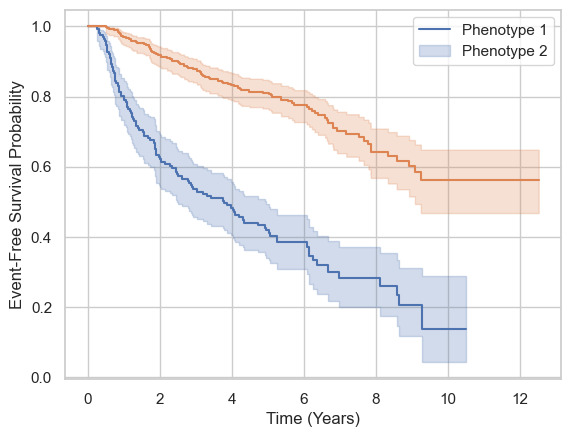

In [ ]:
from auton_survival import reporting
from auton_survival.metrics import phenotype_purity

# Estimate the probability of event-free survival for phenotypes using the Kaplan Meier estimator.
rec, z_sample, p_z_c, p_c_z, risk_scores, lambdas = best_model.predict((x_val.values, y_val.values), verbose=0, batch_size=len(x_val))
# phenotypes = np.argmax(p_c_z, -1)
# phenotypes = np.random.randint(0,1,len(x_val))
reporting.plot_kaplanmeier(y_val, groups=phenotypes)

plt.xlabel('Time (Years)')
plt.ylabel('Event-Free Survival Probability')
plt.legend(['Phenotype 1', 'Phenotype 2'], loc="upper right")
plt.show()

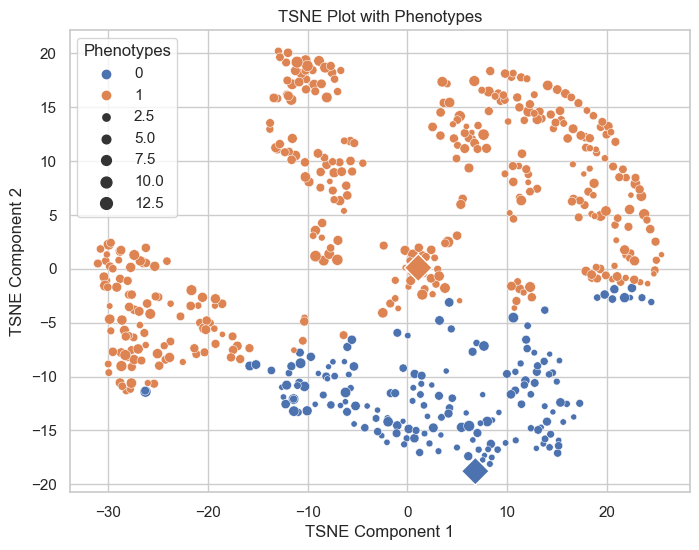

In [59]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=1)
z_mu, z_logvar = best_model.encoder(x_val.values)
zc2 = tsne.fit_transform(np.vstack((z_mu, best_model.c_mu)))
z2, c2 = np.split(zc2, [len(z_mu)])


plt.figure(figsize=(8, 6))
sns.scatterplot(x=z2[:, 0], y=z2[:, 1], hue=phenotypes, size=y_val.time)
sns.scatterplot(x=c2[:, 0], y=c2[:, 1], hue=np.arange(
    len(c2)), s=200, legend=False, marker="D", linewidth=1)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Plot with Phenotypes')
plt.legend(title='Phenotypes', loc='best')
plt.show()

In [6]:
from auton_survival import reporting
from auton_survival.metrics import phenotype_purity
from auton_survival.models.dcm import DeepCoxMixtures
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

# Define parameters for tuning the model
param_grid1 = {'k' : [2],
              'learning_rate' : [1e-3, 1e-4],
              'layers' : [[50, 100],[100]]
             }

params1 = ParameterGrid(param_grid1)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models1 = []
for param in params1:
    model = DeepCoxMixtures(k=param['k'], layers=param['layers'],)
    
    # The fit method is called to train the model
    model.fit(x, y.time, y.event, iters = 100, learning_rate=param['learning_rate'])

    phenotypes = np.argmax(model.predict_latent_z(x_val),-1)
    # Estimate the integrated Brier Score at event horizons of 1, 2 and 5 years
    metric_val1 = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_val, 
                                    phenotypes_test=None, outcomes_test=None,
                                    strategy='integrated', horizons=[6], 
                                    bootstrap=None)
    print(metric_val1)
    # Obtain survival probabilities for validation set and compute the integrated Brier Score 
    # predictions_val = model.predict_survival(x_val, times)
    # metric_val2 = survival_regression_metric('ctd', y_val, predictions_val, times, y_tr)
    # metric_val1 = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models1.append([metric_val1, model, param])
    
models1 = sorted(models1, key=lambda x: x[0], reverse=False)
model = models1[0][1]
print(models1)

 43%|████▎     | 43/100 [00:02<00:02, 21.07it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/vadesc/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/vadesc/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


[0.13687930376950067]


 42%|████▏     | 42/100 [00:02<00:03, 18.82it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/vadesc/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/vadesc/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


[0.13251101723586423]


 14%|█▍        | 14/100 [00:00<00:04, 17.87it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/vadesc/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/vadesc/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


[0.15296137993826467]


 61%|██████    | 61/100 [00:03<00:01, 19.97it/s]

[0.1340742405751269]
[[[0.13251101723586423], <auton_survival.models.dcm.DeepCoxMixtures object at 0x7f3ad02fbb20>, {'k': 2, 'layers': [50, 100], 'learning_rate': 0.0001}], [[0.1340742405751269], <auton_survival.models.dcm.DeepCoxMixtures object at 0x7f39e2b73af0>, {'k': 2, 'layers': [100], 'learning_rate': 0.0001}], [[0.13687930376950067], <auton_survival.models.dcm.DeepCoxMixtures object at 0x7f39ffeb79a0>, {'k': 2, 'layers': [50, 100], 'learning_rate': 0.001}], [[0.15296137993826467], <auton_survival.models.dcm.DeepCoxMixtures object at 0x7f39e2b34b50>, {'k': 2, 'layers': [100], 'learning_rate': 0.001}]]



/u/97/nguyenq10/unix/myconda/.conda_envs/vadesc/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/vadesc/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


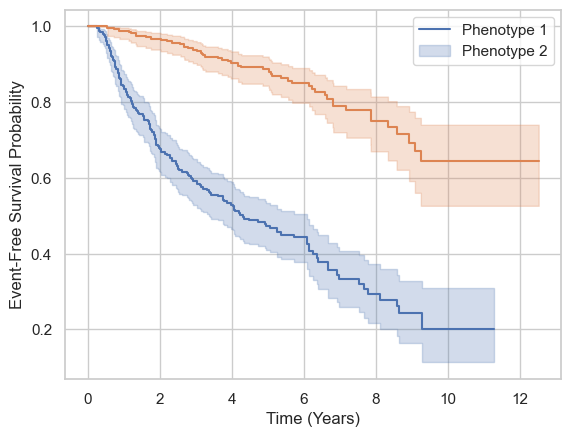

/u/97/nguyenq10/unix/myconda/.conda_envs/vadesc/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/vadesc/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


[0.13251101723586423]

In [7]:
from auton_survival import reporting
import matplotlib.pyplot as plt
from auton_survival.models.dcm.dcm_utilities import predict_latent_z

latent_z_prob = model.predict_latent_z(x_val)
phenotypes = np.argmax(latent_z_prob, axis=-1)
# Estimate the probability of event-free survival for phenotypes using the Kaplan Meier estimator.
reporting.plot_kaplanmeier(y_val, np.array(phenotypes))

plt.xlabel('Time (Years)')
plt.ylabel('Event-Free Survival Probability')
plt.legend(['Phenotype 1', 'Phenotype 2'], loc="upper right")
plt.show()

# Estimate the integrated Brier Score at event horizons of 1, 2 and 5 years
metric = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_val, 
                                phenotypes_test=None, outcomes_test=None,
                                strategy='integrated', horizons=[6], 
                                bootstrap=None)
metric

(array([900.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 900.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

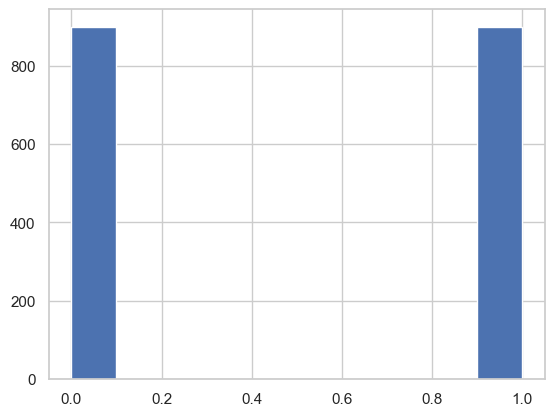

In [10]:
plt.hist(phenotypes)

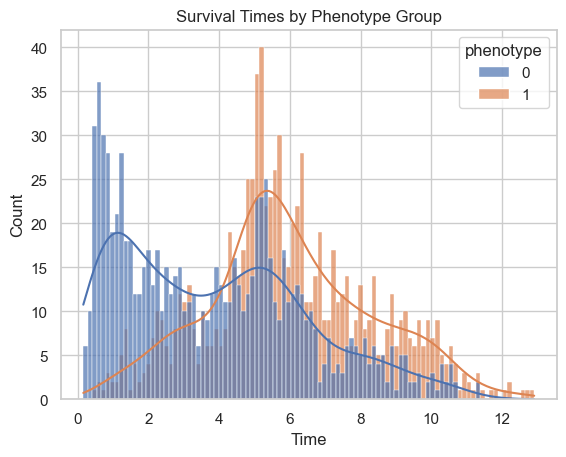

In [9]:
from pandas import DataFrame


latent_z_prob = model.predict_latent_z(x)
phenotypes = np.argmax(latent_z_prob, axis=-1)
# Plot the histogram with a separation by phenotype
sns.histplot(data=DataFrame({'time': y.time, 'phenotype': phenotypes}), x="time", hue="phenotype", kde=True, bins=100, alpha=0.7)

plt.title("Survival Times by Phenotype Group")
plt.xlabel("Time")
plt.ylabel("Count")

plt.show()
# Estimate the probability of event-free survival for phenotypes using the Kaplan Meier estimator.

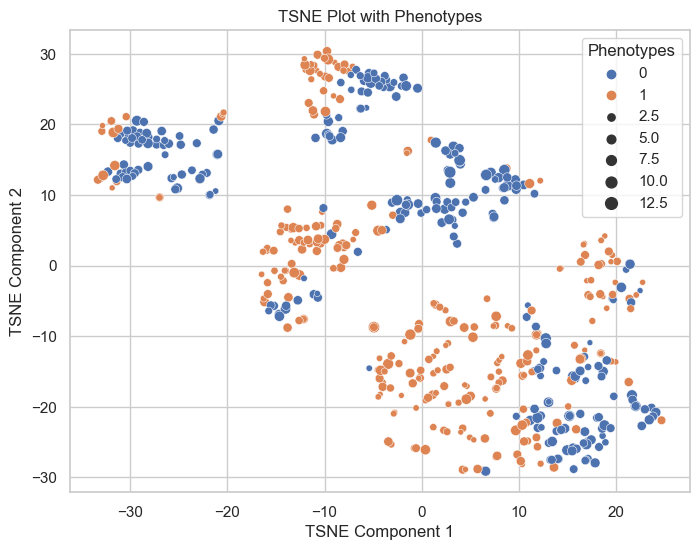

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=1)
x_tsne = tsne.fit_transform(x_val)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=phenotypes, size=y_val.time)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Plot with Phenotypes')
plt.legend(title='Phenotypes', loc='best')
plt.show()
